In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/비타민복프

/content/drive/MyDrive/비타민복프


# [0] smape & vsmape 정의

- smape : 각 smape 의 평균을 도출
- vsmape : 평균 내지 않고 raw한 smape 도출

In [3]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm

def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [4]:
census = pd.read_csv('census_starter.csv')
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


# [1] Basic processing

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
print(train.shape, test.shape, sub.shape)  # (122265, 7) (25080, 3) (25080, 2)

# 1. concatenate train and test
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
# concat train and test data, and sort by cfips first, and then sort by row_id for each cfips
# since row_id has a format 'cfips-first day of month', basically we sort by time
# because we have both train and test, the index is confounded. so we drop the index first and then give the joined table a new index from 0

# 2. change the type of the column 'first_day_of_month' to 'to_datetime'
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

# 3. for each cfips, fill the 'county' and 'state' for the test part by forward fill
# - ffill: propagate last valid observation forward to next valid backfill
# - bfill: use next valid observation to fill gap.
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
# now, test data also have the 'county' and 'state' column value

# 4. - NEW COLUMNS: two year and month columns for both train and test
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month

# 5. - NEW COLUMNS: for each cfips, give each month a unique index from 0 to length of that group - 1.
#                   dcount become the unique index for each month for a cfips.
#                   dcount is the 0-started index for each cfips
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()

# 6. - NEW COLUMNS: encode 'county + state' as unique codes; encode 'state' as unique codes
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]

(122265, 7) (25080, 3) (25080, 2)


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147345 entries, 0 to 147344
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 147345 non-null  object        
 1   cfips                  147345 non-null  int64         
 2   county                 147345 non-null  object        
 3   state                  147345 non-null  object        
 4   first_day_of_month     147345 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  float64       
 7   istest                 147345 non-null  int64         
 8   year                   147345 non-null  int64         
 9   month                  147345 non-null  int64         
 10  dcount                 147345 non-null  int64         
 11  county_i               147345 non-null  int64         
 12  state_i                147345 non-null  int6

In [7]:
raw[raw['cfips']==1001]['dcount']

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
39    39
40    40
41    41
42    42
43    43
44    44
45    45
46    46
Name: dcount, dtype: int64

In [8]:
raw['cfips'].value_counts()
# first two digits > state FIPS code
# following 3  > county
# FIPS code > numbers which uniquely identify geographic areas

1001     47
39133    47
39089    47
39091    47
39093    47
         ..
21113    47
21115    47
21117    47
21119    47
56045    47
Name: cfips, Length: 3135, dtype: int64

# [2] Anomaly Detection

In [9]:
lag = 1

# .shift(lag): for each cfips, shift its density column by lag=1, so the density in each first row will be NAN. -> you get a column with the length = len('density')
# .bfill(): fill NaN with the next valid density, so the density in each cfips' first row will be the original value, but note that
#           1001's density from 2022-12-01 to 2023-06-01 will be back filled by the first density of 1003 (the next cfips), in this new column 'mbd_lag_1'.
#           but, it turns out that doesn't really matter
# NOTE THAT, in the engineering, 'mbd_lag_1' is overwrite by new feature
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

# basically, 'dif' means the 'percentage increment' of the density from the previous month to this month
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

# if there are zeros in density, then we need to deal with special cases:
#    density  mbd_lag_1  div  fillna  clip  diff
#       1         1       1                 -> 0   
#       2         1       2                 -> 1
#       0         2       0                 -> -1
#       0         0      inf                -> inf     special cases
#       4         0      inf                -> inf     special cases
#      Nan        4      Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0

# --------------------------------------------
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0


raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1  
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0 -> 1   # is 1 a reasonable number?
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0

# -------------------------

raw['dif'] = raw['dif'].abs()

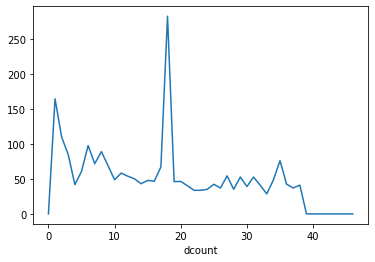

In [10]:
raw.groupby('dcount')['dif'].sum().plot()

## smoothing & outlier correction

In [11]:
outliers = []   # record which cfips has outliners
cnt = 0         # the tot num of outliners

for o in tqdm(raw.cfips.unique()):     # each cfips
    
    indices = (raw['cfips']==o)        # get all the idx for that cfips
    tmp = raw.loc[indices].copy().reset_index(drop=True)   # get all the rows for the cfips, reset_index make each tmp index from zero
    var = tmp.microbusiness_density.values.copy()          # copy density data for the current cfips
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(37, 2, -1):         # idx 37 ~ 3. Note: 0 ~ 38 is training data
                                       # why not consider 38? 2?  # i think you can even set it to 0
        thr = 0.20*np.mean(var[:i])    # use 20% average of the points before current point i as the anomaly value TH
        difa = abs(var[i]-var[i-1])    # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend
        if (difa>=thr):                # so we 'lift' all the previous values to the same 'stage' of the current point
            var[:i] *= (var[i]/var[i-1])
            
            outliers.append(o)         # save which cfips has outliers
            cnt+=1                     # total count
    
    # why not set the above for loop as range(37,0,-1)? so we don't need the line below
    var[0] = var[1]*0.99               # why do this hard code 0.99? make the first -> second unchanged almost? 
    
    raw.loc[indices, 'microbusiness_density'] = var  # the smoothed density
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

<ipython-input-11-a7a58837d5cd>:16: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
<ipython-input-11-a7a58837d5cd>:16: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
<ipython-input-11-a7a58837d5cd>:16: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1])
<ipython-input-11-a7a58837d5cd>:14: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i]-var[i-1])    # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend


(481, 732)

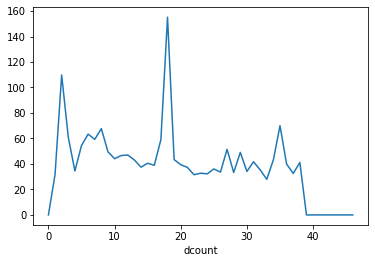

In [14]:
# plot again
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

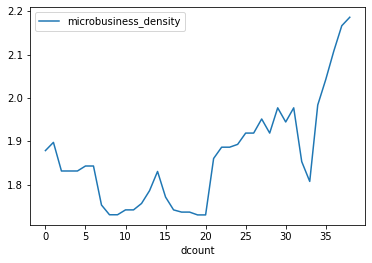

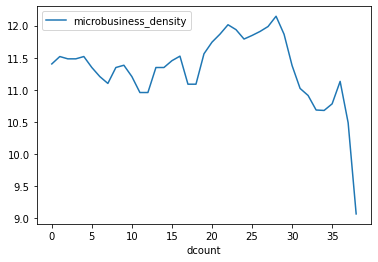

In [15]:
# plot two cfips density change over time
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

- 서로 다른 경향성을 보인다

# [3] SMAPE is a relative metric so target must be converted.

In [1]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)  # shift UP
raw['target'] = raw['target']/raw['microbusiness_density'] - 1   # next / this month - 1 = the next month increment
                                                                 # NOTE: dcount = 38 doesn't have target value - not next month to compare   
# two special cases, hard code to 0.0
raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

NameError: ignored

In [ ]:
raw['target'].clip(-0.05, 0.05).hist(bins=100)

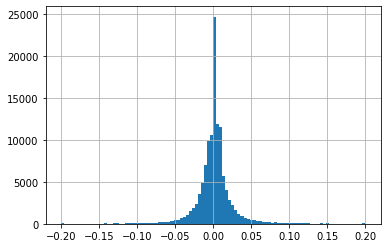

In [18]:
raw['target'].clip(-0.2, 0.2).hist(bins=100)

## COLUMN 'lastactive'

In [30]:
# for each cfips, get the last active value and assign it to the NEW column 'lastactive'
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last') 

raw['lastactive'] > cfips 별로 active 의 마지막 값 

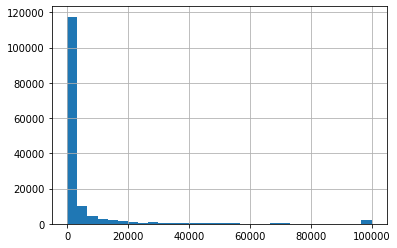

In [31]:
raw['lastactive'].clip(0, 100000).hist(bins=30)

## COLUMN 'lasttarget'

In [32]:
# for each cfips, get dcount=28 (2021-12-01)'s density, so we get
#   cfips    2021-12-01's density
#   1001      3.286307
#   1003      7.930010
#         ...
# dt is a mapping table for the next step
dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')

# basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
# NOTE: this is the actual density value! not the target value. why 28?
raw['lasttarget'] = raw['cfips'].map(dt)

# [4] Feature Engineering

In [33]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    '''
    e.g.,
    target = 'target'
    target_act = 'active'
    lags = 4
    '''
    
    feats = []
    for lag in range(1, lags):  # 1 ~ 3
        
        # for each cfips, shift the 'target' column by 1,2 and 3
        # the original 'target' column has values from 0 to 37, note that dcount = 38 (2022-10-01) doesn't have a target value 
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        
        # for each cfips, the diff between the current avtive value and the previous 1,2,and 3 months' active values
        # the original 'active' column has values from 0 to 38
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        
        # the shifted 'target' and 'active' are taken as features
        # basically, for each month, the previous 1,2,3 months' target and active are taken into consideration
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
    
    # the sum of the previous 2,4,6 months 'target' value
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())   
        
        ## the diff between the previous month and the sum of previous 6 months. the original notebook doesn't use it
        ##raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [34]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 4)

# the state code is a feature
features = ['state_i']
features += feats
print(features)

raw.loc[raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


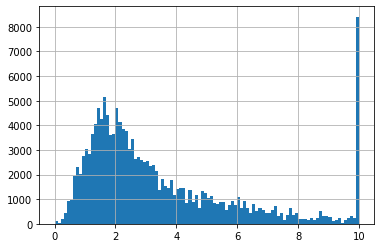

In [35]:
# why do we have to care about 'lasttarget'?
# ' basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
#   NOTE: this is the actual density value! not the target value. why 28?'
raw['lasttarget'].clip(0,10).hist(bins=100)

# [5] MODEL

In [36]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

In [37]:
# threshold
ACT_THR = 1.8
ABS_THR = 1.0

# define 3 new columns for use
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.

VAL = []
BEST_ROUNDS = []

In [40]:
for TS in range(29, 38):  # from 29 to 37.  1) is it the reason why 'lasttarget' use 'dcount=28'?  
                          # the actual density pred you give is 30 to 38  
    print(TS)
    
    # --- define the model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',   # why this objective?
        #objective='reg:squarederror',
        tree_method="hist",                 # 
        n_estimators=4999,                  # iterations
        learning_rate=0.0075,
        max_leaves = 17,    
        subsample=0.50,                     # sample used for each iteration
        colsample_bytree=0.50,              # features used for each iteration
        max_bin=4096,                       # 
        n_jobs=2,
        eval_metric='mae',                  # 
        early_stopping_rounds=70,
    )
    
    # --- get training data
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) & (raw.lasttarget>ABS_THR) 
    #                no test data   |    training month = [1,TS)             |                   1.8     |                    1
    #                                    why not use 0?                                                              
    #                                    because has undefined features, but does 1 has all the features?
    # 
    # note that for each cfips, the 'lastactive' across months are the same, so does the 'lasttarget' column
    # so, you either select all the rows or drop all the row for a cfips
    #
    # ‘lasttarget’: for each cfips, the density in dcount = 28 '2021-12-01'
    # 'lastactive': for each cfips, the last active value (in dcount = 38)  '2022-10-01'
    
    # --- get testing data
    valid_indices = (raw.istest==0) & (raw.dcount == TS)  # note: more cfips than training data, but we exclude some of them later
    
    # --- model fit
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),    # why clip ? the increase or decrease is confined in the range (-0.0043, 0.0045). reasonable?
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    
    # --- save best iteration
    best_rounds = model.get_booster().best_iteration
    BEST_ROUNDS.append(model.get_booster().best_iteration)
    
    # --- pred the current validation set, note the pred is the increment comparing to TS+1
    ypred = model.predict(raw.loc[valid_indices, features])
    
    # becasue we pred the increment for the next month, so we need to add 1
    raw.loc[valid_indices, 'k'] = ypred + 1
    # if you multiple it with 'density' in TS, you get next month TS+1 density prediction
    raw.loc[valid_indices, 'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # --- ACTUALLY, WE ARE PREDICTING **TS+1** ---
    # 1. define two mappings, lastval and dt
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    # for all the current validation TS, get cfips and density
    # then, set cfips to index, so we make a dict -> cfips: the density for TS
    # e.g., { 'microbusiness_density':{1001: 3.2967808, 1003: 7.733397, 1005: 1.1866289, ...} }
    # this is a map for later use
    
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    # e.g., { 'k':{1001: pred for TS+1 month ACTUAL density, 1003: , 1005: , ...} }
    # this is a map for later use
    
    # 2. define a tmp dataframe for the preds of TS+1
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    # get all the cfips's TS+1                                         the 2022-10-01 active |  'target' value in TS
    
    # ATTACH the mappings to df columns
    df['pred'] = df['cfips'].map(dt)         # put TS+1 density pred to 'pred' column of the TS+1 specific df
    df['lastval'] = df['cfips'].map(lastval) # put the TS density to 'lastval' column of df
    
    # FOR SOME CASES, WE DON'T WANT TO USE THE PREDICTIONS BY THE MODEL, INSTEAD, WE WANT TO USE THE TS DENSITY.
    # case1. for each cfips, if the last active in dcount=38 is smaller than ACT_THR, (which means the business scale is considered as small)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    
    # case2. for each cfips, if the TS actual density is smaller than ABS_THR, (which means the recent trend is small?)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    
    # case3. if the state is in the black list, then we don't use the pred above, instead, use the TS density
    #        how to get this blacklist?
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    
    # case4. if the cfips is in the black list, then we don't use the pred above, instead, use the TS density
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    
    # FINALLY, assign the pred to the 'ypred' column of the 'raw' dataframe
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    #          lastval is the actual density in TS, basically, you shift lag=1
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )   # smape if you simply use last density to predict TS+1
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))              # smape if you use the preds
    print()


ind = (raw.dcount >= 30)&(raw.dcount <= 38)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )

29
[0]	validation_0-mae:0.494444
[500]	validation_0-mae:0.015091
[1000]	validation_0-mae:0.010886
[1500]	validation_0-mae:0.010918
[2000]	validation_0-mae:0.010942
[2500]	validation_0-mae:0.010958
[3000]	validation_0-mae:0.010973
[3500]	validation_0-mae:0.01098
[4000]	validation_0-mae:0.01099
[4500]	validation_0-mae:0.010999
[4998]	validation_0-mae:0.011004
TS: 29
Last Value SMAPE: 1.0868726017655663
XGB SMAPE: 1.0957740775618705

30
[0]	validation_0-mae:0.488396
[500]	validation_0-mae:0.013039
[1000]	validation_0-mae:0.013077
[1500]	validation_0-mae:0.013175
[2000]	validation_0-mae:0.013173
[2500]	validation_0-mae:0.013173
[3000]	validation_0-mae:0.013172
[3500]	validation_0-mae:0.013171
[4000]	validation_0-mae:0.01317
[4500]	validation_0-mae:0.013168
[4998]	validation_0-mae:0.013166
TS: 30
Last Value SMAPE: 1.318087470449913
XGB SMAPE: 1.3030440809549337

31
[0]	validation_0-mae:0.494091
[500]	validation_0-mae:0.015437
[1000]	validation_0-mae:0.01118
[1500]	validation_0-mae:0.011194


In [43]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==30), ['cfips', 'microbusiness_density', 'ypred', 'ypred_last','error', 'error_last'] ].head(10)

,cfips,microbusiness_density,ypred,ypred_last,error,error_last
30,1001,3.334431,3.299486,3.296781,1.053530,1.135557
77,1003,7.823300,7.721309,7.733397,1.312239,1.155810
124,1005,1.206827,1.186859,1.186629,1.668412,1.687769
171,1007,1.236650,1.215640,1.214165,1.713464,1.834867
218,1009,1.777708,1.752480,1.752923,1.429281,1.403959
265,1011,0.874082,0.848746,0.848746,2.941173,2.941173
312,1013,1.944535,1.977533,1.977162,1.682670,1.663897
359,1015,2.706717,2.702440,2.701134,0.158126,0.206478
406,1017,1.438767,1.412857,1.412333,1.817237,1.854301
453,1019,1.326550,1.193420,1.193420,10.566032,10.566032


# [6] Some post-hoc analysis after training and validation

## [6.1] which state has the most significant diff between the error (by pred) and the error_last (by last value pred)
for example, it is better to use the actual xgb prediction for the district of columbia, instead of the last prediction.

In [44]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('state')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=True)
dt

<ipython-input-44-2e84048e68a1>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('state')['error', 'error_last'].mean()


,error,error_last,hit
state,,,
Delaware,1.893489,1.964820,-0.071331
Florida,1.083939,1.097365,-0.013426
Utah,1.144170,1.156125,-0.011955
Idaho,1.147848,1.159049,-0.011201
New Jersey,0.692800,0.703606,-0.010805
Nevada,1.634353,1.643848,-0.009495
Alabama,1.467062,1.476452,-0.009390
District of Columbia,0.493936,0.503024,-0.009088
South Carolina,1.146056,1.154938,-0.008882


In [45]:
dt.iloc[-10:,:]

,error,error_last,hit
state,,,
North Dakota,1.656041,1.656041,0.000000
Iowa,1.225780,1.225780,0.000000
Kansas,1.432441,1.432441,0.000000
New Mexico,1.275656,1.275656,0.000000
Vermont,0.951296,0.951296,0.000000
Wisconsin,0.951966,0.951670,0.000296
Missouri,1.415526,1.414962,0.000563
Arkansas,1.568685,1.568010,0.000675
Massachusetts,0.713978,0.710977,0.003001


- BLACK LIST

## [6.2] which month has the biggest error

In [46]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('dcount')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt.loc[dt['hit']>0]
dt

<ipython-input-46-dc9c5477d883>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('dcount')['error', 'error_last'].mean()


,error,error_last,hit
dcount,,,
36,1.302698,1.279794,0.022904
30,1.095774,1.086873,0.008901
33,0.906859,0.897969,0.008890
37,1.038506,1.034315,0.004191
34,1.371898,1.368629,0.003270
32,1.114045,1.125831,-0.011786
31,1.303044,1.318087,-0.015043
38,1.079869,1.101119,-0.021250
35,2.169153,2.203307,-0.034153


## [6.3] stat err for each cfips and dcount, find out which dcount in which cfips has the biggest error diff between error_last and error

In [47]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False).reset_index()
dt.loc[dt['hit']>0]
dt.head(20)

<ipython-input-47-c31b9037d907>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].mean()


,cfips,dcount,error,error_last,hit
0,10005,33,3.824927,3.432069,0.392858
1,47157,36,0.557699,0.238123,0.319576
2,36005,36,1.064851,0.764032,0.300818
3,36005,33,0.531232,0.233820,0.297412
4,12031,36,0.805997,0.510571,0.295425
5,37119,36,0.650401,0.363746,0.286655
6,17197,33,0.313120,0.035581,0.277539
7,42003,32,2.057611,1.787598,0.270013
8,45077,38,0.269859,0.000000,0.269859
9,1103,33,0.904951,0.636820,0.268131


- TOP 300 cfips with big diff, maybe duplicate inside

## [6.4] TOP county that shouldn't use pred. instead, we should use last_value!

In [48]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('cfips')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt = dt.loc[dt['hit']>0.00]
dt

<ipython-input-48-a183b0b439aa>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('cfips')['error', 'error_last'].mean()


,error,error_last,hit
cfips,,,
29510,0.659717,0.599167,0.060550
54107,1.299229,1.241854,0.057374
42049,0.474938,0.424529,0.050408
29165,0.796681,0.746452,0.050229
13045,0.760453,0.711303,0.049150
...,...,...,...
42119,0.631036,0.630933,0.000103
40087,0.967990,0.967888,0.000102
1115,0.831935,0.831893,0.000042


In [49]:
dt.index

Int64Index([29510, 54107, 42049, 29165, 13045, 17043, 51650,  4025, 22051,
            29071,
            ...
             1009, 48061, 28085, 42037, 51133, 42119, 40087,  1115, 27061,
            12079],
           dtype='int64', name='cfips', length=513)

## [6.5]

In [50]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt

<ipython-input-50-67288f6f608a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()


error  error_last   miss
cfips dcount                             
1001  30      1.053530    1.135557  False
      31      0.014936    0.070548  False
      32      1.023465    1.052261  False
      33      1.818169    1.759945   True
      34      1.038209    0.989406   True
...                ...         ...    ...
56045 34      0.000000    0.000000  False
      35      0.000000    0.000000  False
      36      0.995027    0.995027  False
      37      0.000000    0.000000  False
      38      0.000000    0.000000  False

[28215 rows x 3 columns]

- for each county, the % that our XGB pred does worse than last preds

In [51]:
dt = dt.groupby('cfips')['miss'].mean()
dt

cfips
1001     0.444444
1003     0.444444
1005     0.444444
1007     0.444444
1009     0.555556
           ...   
56037    0.000000
56039    0.444444
56041    0.444444
56043    0.000000
56045    0.000000
Name: miss, Length: 3135, dtype: float64

- if 50% XGB preds is worse than the last pred, show me these county

In [52]:
dt = dt.loc[dt>=0.50]
dt.index

Int64Index([ 1009,  1031,  1081,  1097,  1109,  4003,  4005,  4007,  4011,
             4019,
            ...
            55111, 55121, 55129, 55135, 55141, 56003, 56005, 56013, 56025,
            56035],
           dtype='int64', name='cfips', length=549)

In [53]:
','.join([str(i) for i in dt.index])

'1009,1031,1081,1097,1109,4003,4005,4007,4011,4019,4025,5015,5023,5037,5045,5049,5051,5059,5061,5069,5097,5101,5105,5131,5135,5149,6001,6007,6011,6017,6021,6029,6031,6039,6043,6049,6059,6063,6065,6067,6069,6073,6077,6079,6081,6083,6085,6087,6089,6091,6107,6113,8005,8013,8029,8031,8033,8041,8063,8077,8079,8081,8095,9005,9011,9013,11001,12023,12027,12035,12037,12045,12057,12073,12079,12083,12086,12087,12091,12095,12103,12113,12115,12117,12119,12123,12133,13009,13021,13031,13045,13051,13063,13071,13077,13087,13089,13097,13103,13115,13131,13137,13141,13149,13151,13153,13157,13159,13169,13177,13179,13187,13191,13197,13205,13213,13215,13219,13223,13253,13255,13275,13299,13303,13313,15003,16009,16053,16059,16071,16079,17005,17027,17037,17041,17043,17053,17091,17093,17097,17099,17111,17129,17149,17155,17163,17183,17195,17201,18005,18011,18027,18029,18033,18043,18055,18065,18067,18077,18081,18089,18095,18097,18105,18117,18119,18133,18141,18147,18155,18161,18167,18169,18173,18175,18181,21005,210

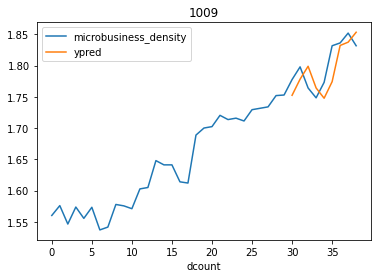

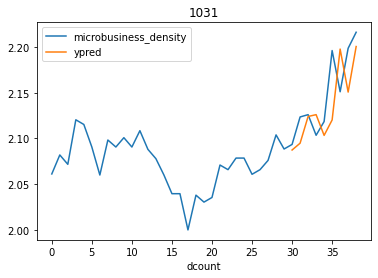

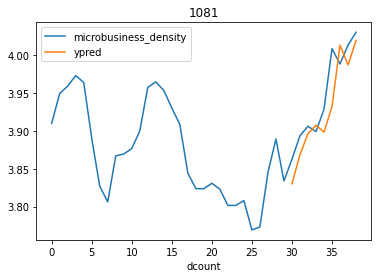

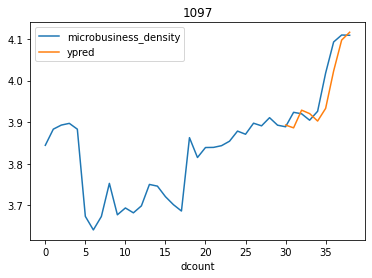

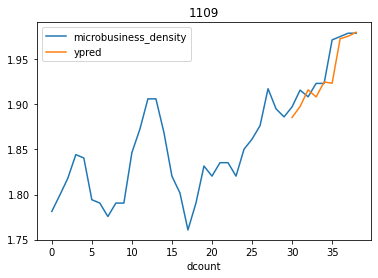

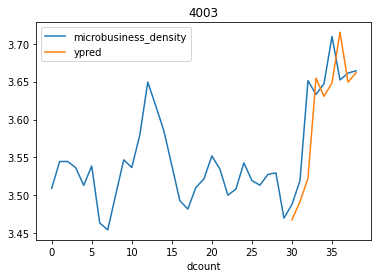

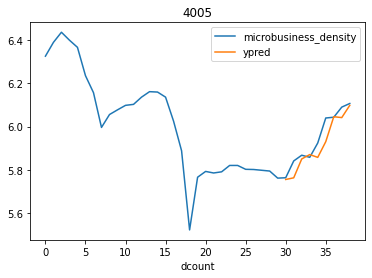

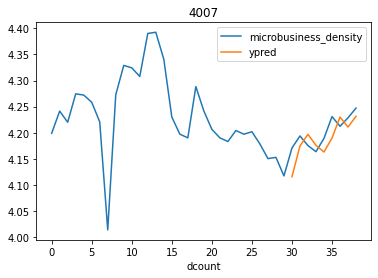

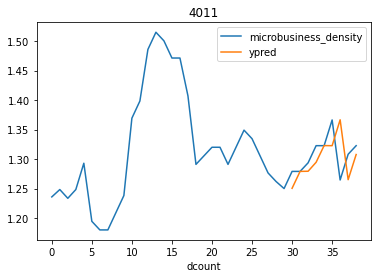

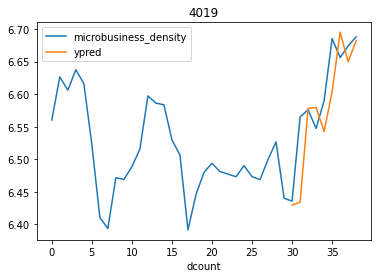

In [54]:
# show me the preds, WHY WHERE IS A LAG?????
for d in dt.index[:10]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))

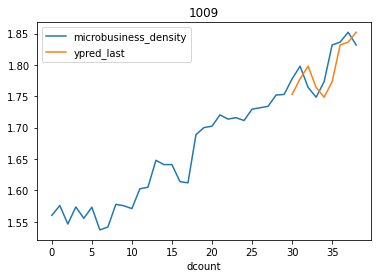

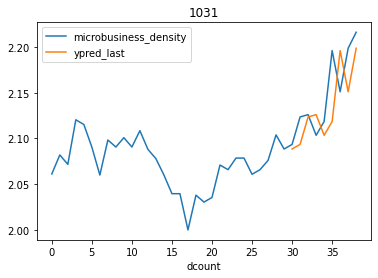

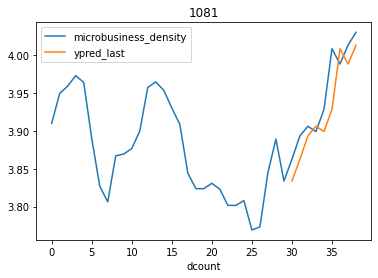

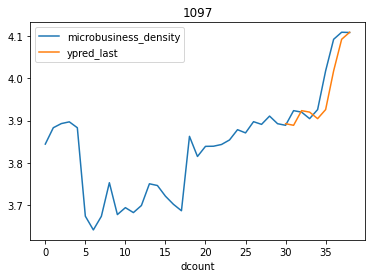

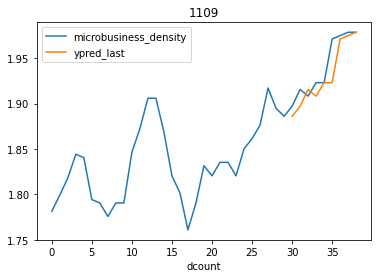

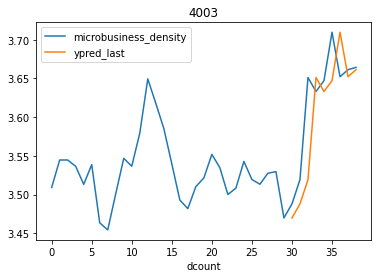

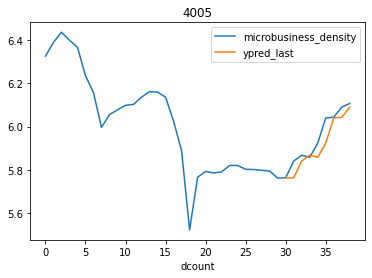

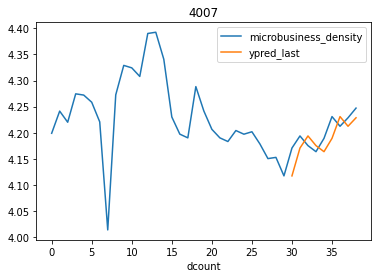

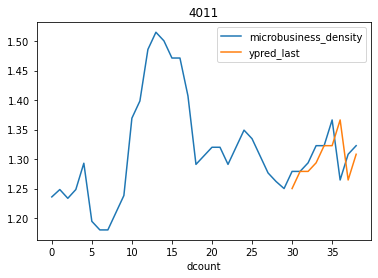

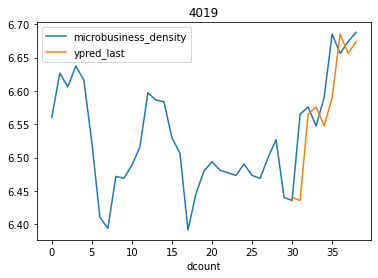

In [55]:
# show me the preds, WHY WHERE IS A LAG?????
for d in dt.index[:10]:
   # raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))

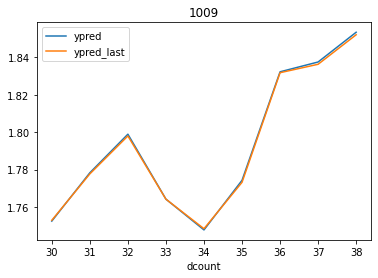

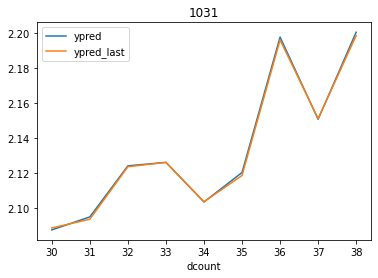

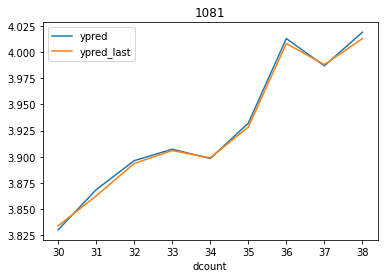

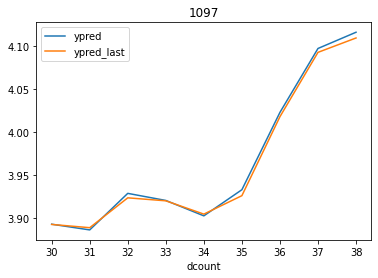

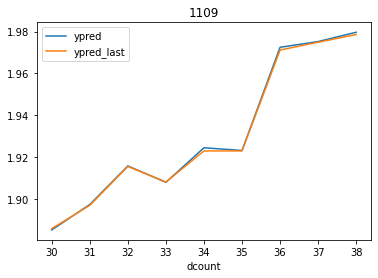

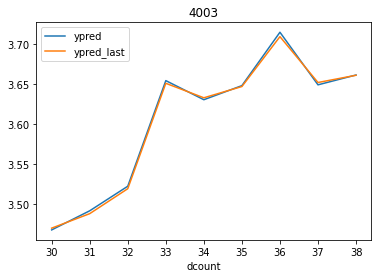

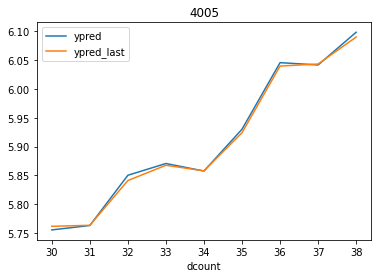

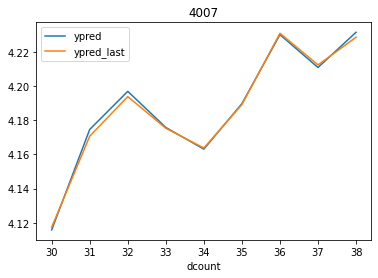

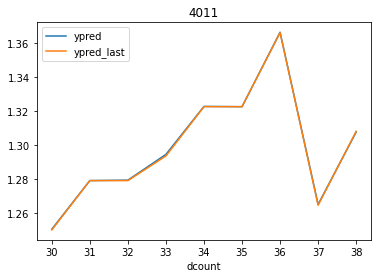

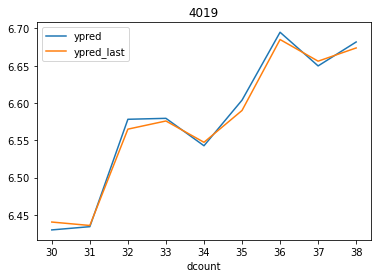

In [56]:
# show me the preds, WHY WHERE IS A LAG?????
for d in dt.index[:10]:
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
    raw.loc[raw.cfips==d].plot(x='dcount', y=['ypred', 'ypred_last'], title=str(d))

## [6.6]

In [57]:
df = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].copy().reset_index(drop=True)
print( smape(df['microbusiness_density'], df['ypred']) )

1.2646496526801994


In [58]:
dt = df.groupby(['cfips','dcount'])['error', 'error_last'].sum()
dt['hit'] = 1*(dt['error'] < dt['error_last'])
dt

<ipython-input-58-67fa858a8a69>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = df.groupby(['cfips','dcount'])['error', 'error_last'].sum()


error  error_last  hit
cfips dcount                           
1001  30      1.053530    1.135557    1
      31      0.014936    0.070548    1
      32      1.023465    1.052261    1
      33      1.818169    1.759945    0
      34      1.038209    0.989406    0
...                ...         ...  ...
56045 34      0.000000    0.000000    0
      35      0.000000    0.000000    0
      36      0.995027    0.995027    0
      37      0.000000    0.000000    0
      38      0.000000    0.000000    0

[28215 rows x 3 columns]

In [59]:
dt = dt.groupby('cfips')['hit'].mean().sort_values(ascending=True)
dt

cfips
29173    0.0
32023    0.0
32017    0.0
32009    0.0
32005    0.0
        ... 
17049    1.0
1095     1.0
16021    1.0
26085    1.0
17135    1.0
Name: hit, Length: 3135, dtype: float64

In [60]:
# top 800 county that should use last_value prediction, NOT XGB predictions
toplist = list(dt.index[:800])
#print(toplist)

# 
df.loc[df.cfips.isin(toplist), 'ypred'] = df.loc[df.cfips.isin(toplist), 'ypred_last']
print( smape(df['microbusiness_density'], df['ypred']) )

1.2646349868503377


# [7] LET'S GET THE PREDICTIONS FOR TS=38+1, WHICH IS 2022-11-01

In [61]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

(4998.0, 4998.0, [4998, 4998, 4998, 4998, 4998, 4998, 4998, 4998, 4998])

In [62]:
best_rounds = int(np.median( BEST_ROUNDS )+1)
best_rounds

4999

In [66]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:squarederror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,  # now we have best round, so no early stopping
    learning_rate=0.0075,
    max_leaves = 31,           # the model used above has 17
    subsample=0.60,            # the model used above has 0.50 
    colsample_bytree=0.50,     
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',           
)

model1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)

# I don't understand why we need two identical models. and then do a half / half ensemble
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features])) / 2

raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density'] # this is the pred for TS+1 = 39, although it is at TS

# two mappings
# 1. each cfips' microbusiness density in TS
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
# 2. each cfips' TS+1 prediction
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

38


In [67]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df

,cfips,microbusiness_density,state,lastactive,mbd_lag_1
0,1001,NaN,Alabama,1472.0,NaN
1,1003,NaN,Alabama,14320.0,NaN
2,1005,NaN,Alabama,244.0,NaN
3,1007,NaN,Alabama,229.0,NaN
4,1009,NaN,Alabama,813.0,NaN
...,...,...,...,...,...
3130,56037,NaN,Wyoming,905.0,NaN
3131,56039,NaN,Wyoming,5035.0,NaN
3132,56041,NaN,Wyoming,582.0,NaN
3133,56043,NaN,Wyoming,189.0,NaN


In [68]:
df['pred'] = df['cfips'].map(dt)           # assign predictions to TS+1
df['lastval'] = df['cfips'].map(lastval)   # assign TS density values

In [69]:
df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [70]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].head(50)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
0,1001,2.856021,0,NaN,NaN,1.000000
1,1001,2.884870,1,NaN,NaN,1.000000
2,1001,3.055843,2,NaN,NaN,1.000000
3,1001,2.993233,3,NaN,NaN,1.000000
4,1001,2.993233,4,NaN,NaN,1.000000
5,1001,2.969090,5,NaN,NaN,1.000000
6,1001,2.909326,6,NaN,NaN,1.000000
7,1001,2.933231,7,NaN,NaN,1.000000
8,1001,3.000167,8,NaN,NaN,1.000000
9,1001,3.004948,9,NaN,NaN,1.000000


In [71]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

test[['row_id','microbusiness_density']].to_csv('submission.csv', index=False)
test.head(50)

,row_id,cfips,microbusiness_density
39,1001_2022-11-01,1001,3.464686
40,1001_2022-12-01,1001,3.464686
41,1001_2023-01-01,1001,3.464686
42,1001_2023-02-01,1001,3.464686
43,1001_2023-03-01,1001,3.464686
44,1001_2023-04-01,1001,3.464686
45,1001_2023-05-01,1001,3.464686
46,1001_2023-06-01,1001,3.464686
86,1003_2022-11-01,1003,8.371060
87,1003_2022-12-01,1003,8.371060
